2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Neural Network Performance:
R² Score: 0.9400
MSE: 168.3333
MAE: 9.9330

Linear Regression Performance:
R² Score: 0.9061
MSE: 263.4468
MAE: 13.3040

Random Forest Performance:
R² Score: 0.9477
MSE: 146.8207
MAE: 9.5220


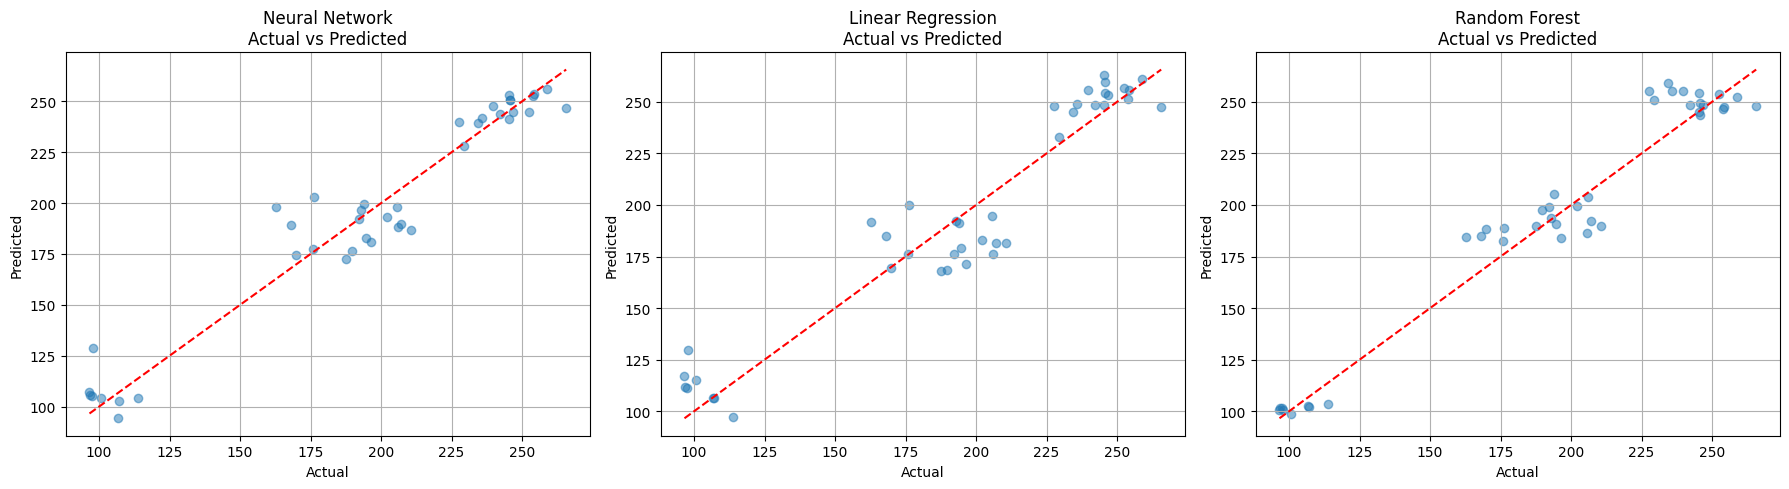

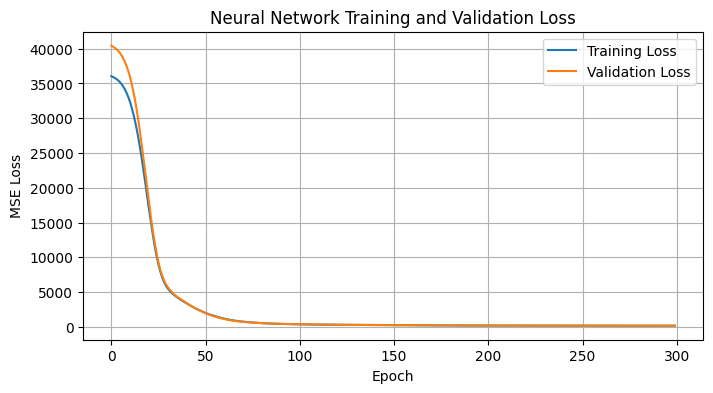

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Predicted Bearing Capacities for BH-5 and BH-6:
Neural Network: BH-5 = 214.89 KN/m², BH-6 = 142.51 KN/m²
Linear Regression: BH-5 = 214.00 KN/m², BH-6 = 139.21 KN/m²
Random Forest: BH-5 = 189.82 KN/m², BH-6 = 108.96 KN/m²


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ----------------------------
# 1. Your original real data (BH-1 to BH-4)
# ----------------------------
base_data = {
    'Depth': [12, 10, 10, 9],
    'N_value': [42, 30, 35, 15],
    'Groundwater_depth': [5, 5.5, 5.5, 6],
    'Boulder_presence': [1, 0.5, 0.5, 0],
    'Bearing_capacity': [250, 200, 180, 100]
}
df = pd.DataFrame(base_data)

# ----------------------------
# 2. Generate Synthetic Data
# ----------------------------
def generate_synthetic(df, n_samples=200):
    synthetic_rows = []
    for _ in range(n_samples):
        idx = np.random.choice(df.index)
        row = df.loc[idx].copy()
        row['Depth'] += np.random.normal(0, 1)
        row['N_value'] += np.random.normal(0, 5)
        row['Groundwater_depth'] += np.random.normal(0, 0.5)
        row['Boulder_presence'] += np.random.normal(0, 0.1)
        row['Boulder_presence'] = np.clip(row['Boulder_presence'], 0, 1)
        row['Bearing_capacity'] += np.random.normal(0, 10)
        synthetic_rows.append(row)
    return pd.DataFrame(synthetic_rows)

df_synth = generate_synthetic(df, 200)

# Combine real + synthetic
df_full = pd.concat([df, df_synth], ignore_index=True)

# ----------------------------
# 3. Prepare features & target
# ----------------------------
X = df_full.drop(columns=['Bearing_capacity'])
y = df_full['Bearing_capacity']

# Scale features for neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ===========================
# MODEL 1: Neural Network (MLP)
# ===========================
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=8,
    callbacks=[early_stop],
    verbose=0
)

y_pred_nn = model.predict(X_val).flatten()

r2_nn = r2_score(y_val, y_pred_nn)
mse_nn = mean_squared_error(y_val, y_pred_nn)
mae_nn = mean_absolute_error(y_val, y_pred_nn)

print("Neural Network Performance:")
print(f"R² Score: {r2_nn:.4f}")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")

# ===========================
# MODEL 2: Linear Regression
# ===========================
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)

r2_lr = r2_score(y_val, y_pred_lr)
mse_lr = mean_squared_error(y_val, y_pred_lr)
mae_lr = mean_absolute_error(y_val, y_pred_lr)

print("\nLinear Regression Performance:")
print(f"R² Score: {r2_lr:.4f}")
print(f"MSE: {mse_lr:.4f}")
print(f"MAE: {mae_lr:.4f}")

# ================================
# MODEL 3: Random Forest Regressor
# ================================
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)

r2_rf = r2_score(y_val, y_pred_rf)
mse_rf = mean_squared_error(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"R² Score: {r2_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

# ---------------------------
# Plot Actual vs Predicted for all models
# ---------------------------
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.scatter(y_val, y_pred_nn, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Neural Network\nActual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.subplot(1,3,2)
plt.scatter(y_val, y_pred_lr, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Linear Regression\nActual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.subplot(1,3,3)
plt.scatter(y_val, y_pred_rf, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title("Random Forest\nActual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()

# ---------------------------
# Plot training/validation loss for NN to check overfitting/underfitting
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# Predict Bearing Capacity for BH-5 and BH-6
# ---------------------------
bh5 = {'Depth': 11, 'N_value': 35, 'Groundwater_depth': 5, 'Boulder_presence': 0.7}
bh6 = {'Depth': 9,  'N_value': 25, 'Groundwater_depth': 5, 'Boulder_presence': 0.2}

bh_new = pd.DataFrame([bh5, bh6])

# Scale features for NN and other models
bh_new_scaled = scaler.transform(bh_new)

# Predictions
pred_nn = model.predict(bh_new_scaled).flatten()
pred_lr = lr.predict(bh_new_scaled)
pred_rf = rf.predict(bh_new_scaled)

print("\nPredicted Bearing Capacities for BH-5 and BH-6:")
print(f"Neural Network: BH-5 = {pred_nn[0]:.2f} KN/m², BH-6 = {pred_nn[1]:.2f} KN/m²")
print(f"Linear Regression: BH-5 = {pred_lr[0]:.2f} KN/m², BH-6 = {pred_lr[1]:.2f} KN/m²")
print(f"Random Forest: BH-5 = {pred_rf[0]:.2f} KN/m², BH-6 = {pred_rf[1]:.2f} KN/m²")


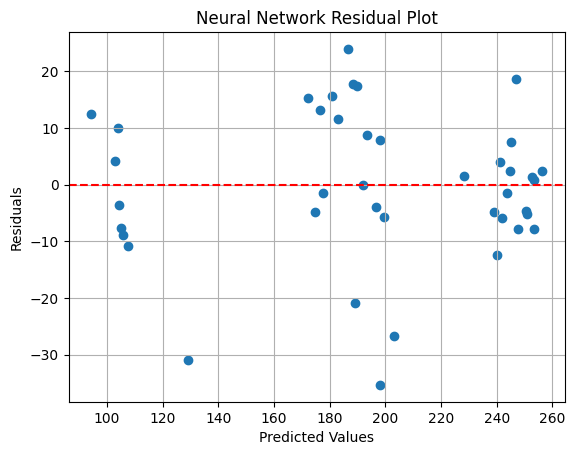

In [2]:
residuals_nn = y_val - y_pred_nn
plt.scatter(y_pred_nn, residuals_nn)
plt.axhline(0, color='red', linestyle='--')
plt.title('Neural Network Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


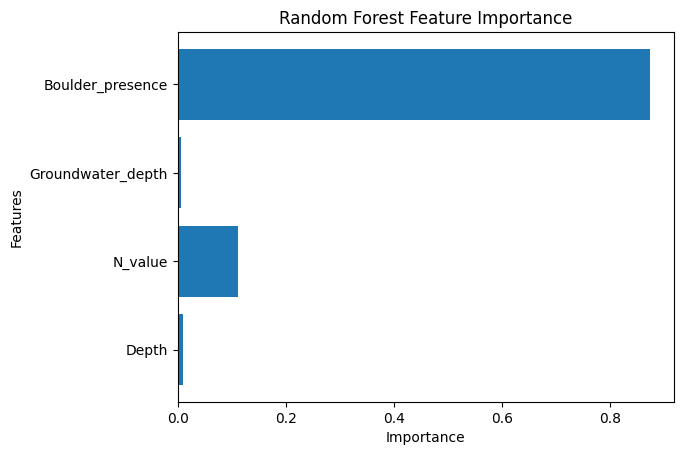

In [3]:
importances = rf.feature_importances_
features = X.columns

plt.barh(features, importances)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()


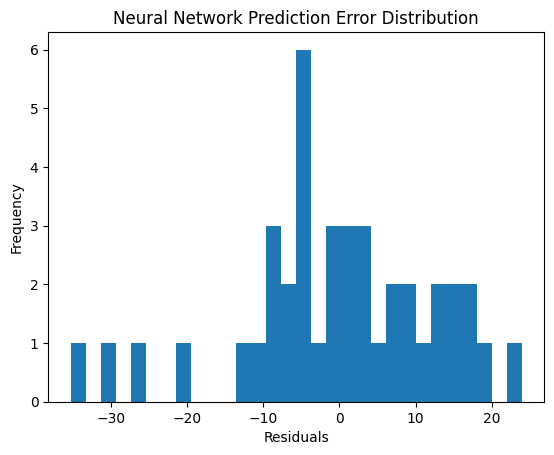

In [4]:
plt.hist(residuals_nn, bins=30)
plt.title("Neural Network Prediction Error Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [5]:
sns.boxplot(data=[df['Depth'], df_synth['Depth']], notch=True)
plt.xticks([0, 1], ['Real Depth', 'Synthetic Depth'])
plt.title("Depth Distribution: Real vs Synthetic")
plt.show()


NameError: name 'sns' is not defined

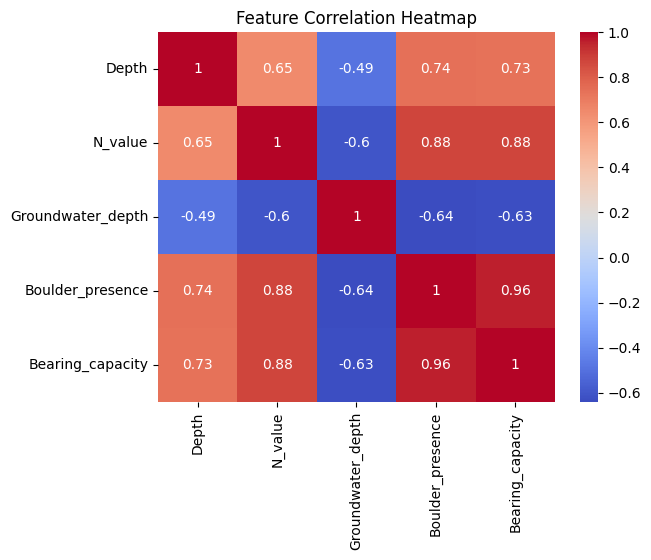

In [6]:
import seaborn as sns
sns.heatmap(df_full.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


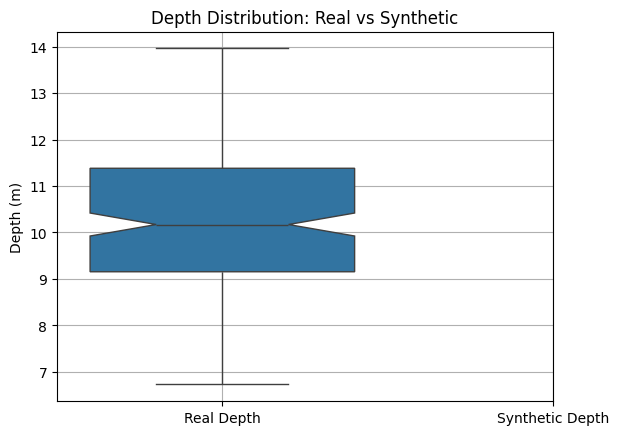

In [7]:
import seaborn as sns

sns.boxplot(data=[df['Depth'], df_synth['Depth']], notch=True)
plt.xticks([0, 1], ['Real Depth', 'Synthetic Depth'])
plt.title("Depth Distribution: Real vs Synthetic")
plt.ylabel("Depth (m)")
plt.grid(True)
plt.show()


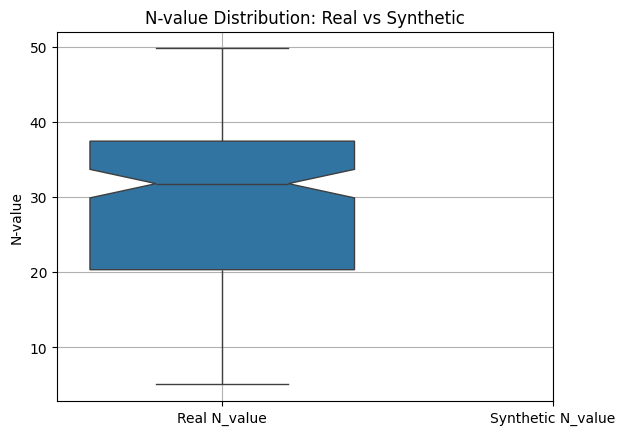

In [8]:
sns.boxplot(data=[df['N_value'], df_synth['N_value']], notch=True)
plt.xticks([0, 1], ['Real N_value', 'Synthetic N_value'])
plt.title("N-value Distribution: Real vs Synthetic")
plt.ylabel("N-value")
plt.grid(True)
plt.show()


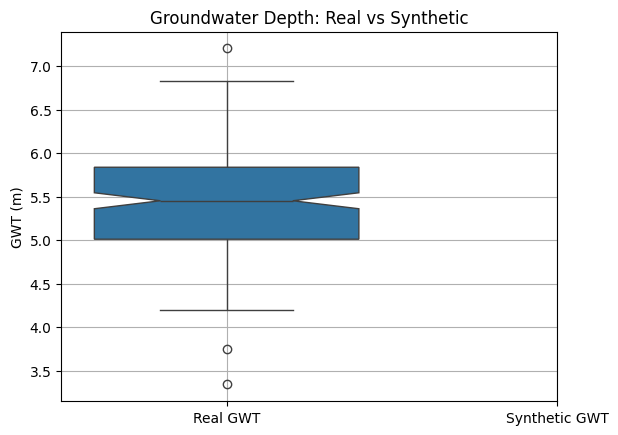

In [9]:
sns.boxplot(data=[df['Groundwater_depth'], df_synth['Groundwater_depth']], notch=True)
plt.xticks([0, 1], ['Real GWT', 'Synthetic GWT'])
plt.title("Groundwater Depth: Real vs Synthetic")
plt.ylabel("GWT (m)")
plt.grid(True)
plt.show()


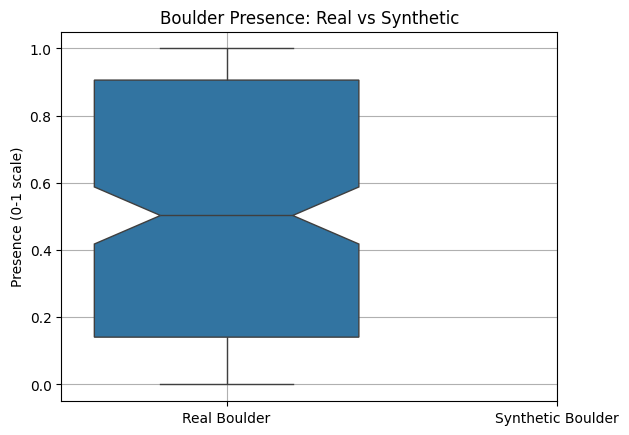

In [10]:
sns.boxplot(data=[df['Boulder_presence'], df_synth['Boulder_presence']], notch=True)
plt.xticks([0, 1], ['Real Boulder', 'Synthetic Boulder'])
plt.title("Boulder Presence: Real vs Synthetic")
plt.ylabel("Presence (0-1 scale)")
plt.grid(True)
plt.show()


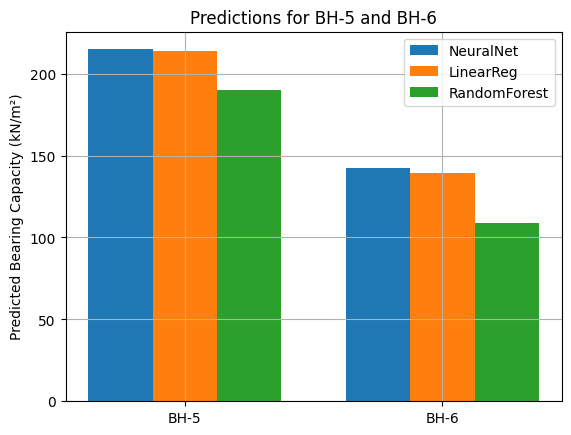

In [11]:
labels = ['BH-5', 'BH-6']
x = np.arange(len(labels))
width = 0.25

plt.bar(x - width, pred_nn, width, label='NeuralNet')
plt.bar(x, pred_lr, width, label='LinearReg')
plt.bar(x + width, pred_rf, width, label='RandomForest')

plt.xticks(x, labels)
plt.ylabel("Predicted Bearing Capacity (kN/m²)")
plt.title("Predictions for BH-5 and BH-6")
plt.legend()
plt.grid(True)
plt.show()
